In [231]:
# importing relevant modules
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


In [206]:
# data import
df_red = pd.read_csv('winequality-red.csv', sep= ';')
df_white = pd.read_csv('winequality-white.csv', sep= ';')

In [207]:
# creating a new column called "quality_label", we define a range and associate that range with a label
df_red ['quality_label'] = df_red['quality'].apply(lambda value: 'low'
if value <= 5 else 'medium'
if value <= 7 else 'high')

# transforming these labels into categrical data type (specific to pandas) instead of simple string
df_red ['quality_label'] = pd.Categorical(df_red['quality_label'],
categories=['low', 'medium', 'high'])

# creating a new column called "quality_label", we define a range and associate that range with a label
df_white ['quality_label'] = df_white['quality'].apply(lambda value: 'low'
if value <= 5 else 'medium'
if value <= 7 else 'high')

# transforming these labels into categrical data type (specific to pandas) instead of simple string
df_white['quality_label'] = pd.Categorical(df_white['quality_label'],
categories=['low', 'medium', 'high'])

# Addition of column of type of wine (white or red) before concatenating (Pandas)
df_red['type'] = df_red.apply(lambda value: 'red')
df_red['type'] = df_red['type'].fillna('red')

# Addition of column of type of wine (white or red) before concatenating (Pandas)
df_white ['type'] = df_white.apply(lambda value: 'white')
df_white ['type'] = df_white['type'].fillna('white')

print(df_red.shape)
print(df_white.shape)

(1599, 14)
(4898, 14)


In [208]:
# dropping duplicates to avoid inconsistencies in data analysis

df_red.drop_duplicates(inplace=True)
df_white.drop_duplicates(inplace=True)

In [209]:
# quick review of data shape without duplicates

print(df_red.shape)
print(df_white.shape)

(1359, 14)
(3961, 14)


In [210]:
# merge of data sets and index readjustement
df_mix = pd.concat([df_red, df_white])
df_mix.reset_index(inplace=True) # when merging previous data frames each index will stay as it was so it is important to reset it to have a new one   
df_mix.pop('index') # reseting index shifts previous one into a column, so the created "index column" needs to be deleted (it is not useful)
#

0          0
1          1
2          2
3          3
4          5
        ... 
5315    4893
5316    4894
5317    4895
5318    4896
5319    4897
Name: index, Length: 5320, dtype: int64

In [211]:
# shape of the merged dataframe should be the sum of the merged data frames
df_mix.shape

(5320, 14)

In [212]:
df_mix.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label,type
5315,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,medium,white
5316,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,low,white
5317,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,medium,white
5318,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,medium,white
5319,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,medium,white


Start of ML model prep

In [213]:
# data encoding for categorical/non numerical data

df_mix_enc = df_mix['type'].replace({'red':0, 'white':1}, inplace=True) # object encoder for type (relevant when encoded)

quality_order = [['low', 'medium', 'high']]

o_enc = OrdinalEncoder(categories=quality_order) # ordinal encoder used for categorical multiclass data

encoded_data = o_enc.fit_transform(df_mix[['quality_label']])

df_mix['quality_label_encoded']= encoded_data.astype(int)

df_mix_enc= df_mix.drop('quality_label', axis=1)

In [214]:
#data split

X = df_mix_enc.drop(['quality_label_encoded','quality', 'alcohol'], axis=1)
y= df_mix_enc['quality_label_encoded']

Function definition for ML Model execution and evaluation report generation 

In [215]:
# function definition with output from ChatGPT for coding efficiency 
# rationale is to have a function where you simply pass the ML model you want to test having prepared your data (preprocessing) 

def train_and_evaluate_models(models, X, y, test_size=0.35, random_state=42): # this function will be reused each time an additional/new ML model is used without having to code each from scratch  
    """
    Train and evaluate multiple machine learning models.
    
    Parameters:
        models (dict): A dictionary containing the models to train, where the keys are model names and the values are model instances.
        X (DataFrame or array-like): Features.
        y (Series or array-like): Target variable.
        test_size (float, optional): The proportion of the dataset to include in the test split.
        random_state (int, optional): Random seed for reproducibility.
        
    Returns:
        dict: A dictionary containing the classification reports for each model.
    """
    # splitting data in test and train. Note no validation data used.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # dict to store rhe classification reports for each model
    reports = {}
    
    # the below loop will iterate over each provided model:
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Evaluate the model
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred)

        # Store the classification report for the model
        reports[model_name] = report
        
    return reports

In [216]:
# Models defined in batch to be passed on to the function to avoid passing one-by-one
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
}

# Call the function to train and evaluate the models
classification_reports = train_and_evaluate_models(models, X, y)

# Print the classification reports for each model
for model_name, report in classification_reports.items():
    print(f"Classification report for {model_name}:\n{report}\n")

c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       703
           1       0.75      0.84      0.79      1113
           2       0.00      0.00      0.00        46

    accuracy                           0.74      1862
   macro avg       0.49      0.49      0.49      1862
weighted avg       0.72      0.74      0.72      1862


Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.60      0.26      0.36       703
           1       0.64      0.89      0.74      1113
           2       0.00      0.00      0.00        46

    accuracy                           0.63      1862
   macro avg       0.41      0.38      0.37      1862
weighted avg       0.61      0.63      0.58      1862


Classification report for SVM:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       703
        

Function below incorporates plotting confusion matrix per model and bar chart with overall scores across models for comparison

In [217]:
def train_and_evaluate_models(models, X, y):
    """
    Train multiple machine learning models, evaluate their performance,
    and plot the results including confusion matrices.
    
    Parameters:
        models (dict): A dictionary containing names of models as keys
                       and corresponding scikit-learn model objects as values.
        X (DataFrame or array-like): Features.
        y (array-like): Target variable.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)
    
    # Initialize lists to store model names, accuracy scores, and confusion matrices
    model_names = []
    accuracy_scores = []
    confusion_matrices = []
    
    # Loop through each model
    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Evaluate the model
        y_pred = model.predict(X_test)
        accuracy = model.score(X_test, y_test)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Store the results
        model_names.append(name)
        accuracy_scores.append(accuracy)
        confusion_matrices.append(conf_matrix)
        
        # Plot confusion matrix
        plt.figure(figsize=(6, 6))
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
                    xticklabels=model.classes_, yticklabels=model.classes_)
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # Print classification report
        print(f"Classification Report - {name}:")
        print(report)
        print("="*60)
        
    # Plot accuracy scores
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, accuracy_scores, color='skyblue')
    plt.title('Accuracy Scores of Models')
    plt.xlabel('Models')
    plt.ylabel('Accuracy Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.show()

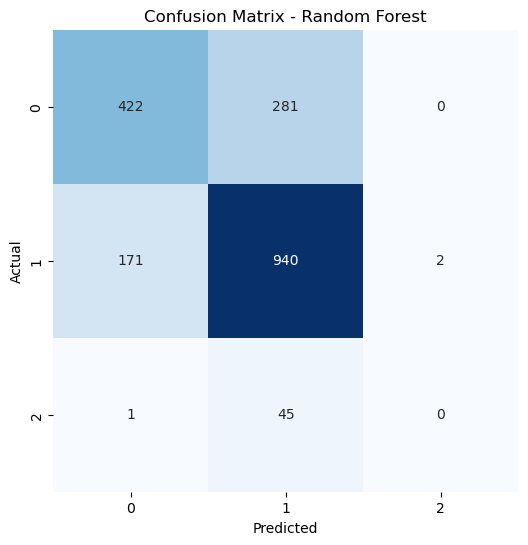

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65       703
           1       0.74      0.84      0.79      1113
           2       0.00      0.00      0.00        46

    accuracy                           0.73      1862
   macro avg       0.48      0.48      0.48      1862
weighted avg       0.71      0.73      0.72      1862



c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


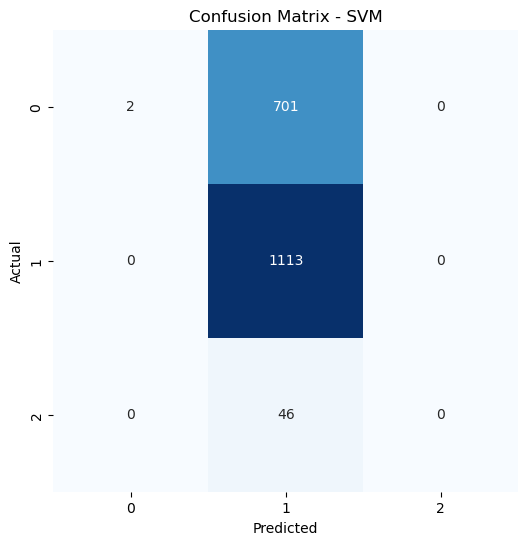

Classification Report - SVM:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       703
           1       0.60      1.00      0.75      1113
           2       0.00      0.00      0.00        46

    accuracy                           0.60      1862
   macro avg       0.53      0.33      0.25      1862
weighted avg       0.74      0.60      0.45      1862



c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

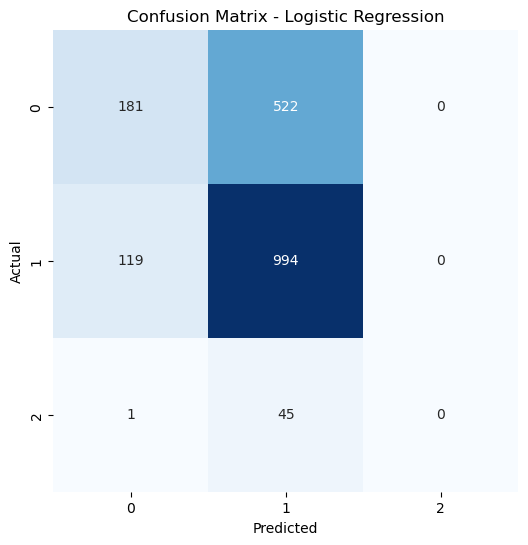

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.60      0.26      0.36       703
           1       0.64      0.89      0.74      1113
           2       0.00      0.00      0.00        46

    accuracy                           0.63      1862
   macro avg       0.41      0.38      0.37      1862
weighted avg       0.61      0.63      0.58      1862



c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


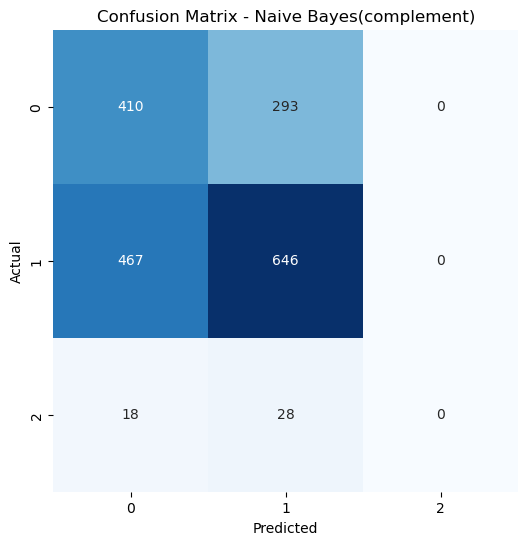

Classification Report - Naive Bayes(complement):
              precision    recall  f1-score   support

           0       0.46      0.58      0.51       703
           1       0.67      0.58      0.62      1113
           2       0.00      0.00      0.00        46

    accuracy                           0.57      1862
   macro avg       0.38      0.39      0.38      1862
weighted avg       0.57      0.57      0.57      1862



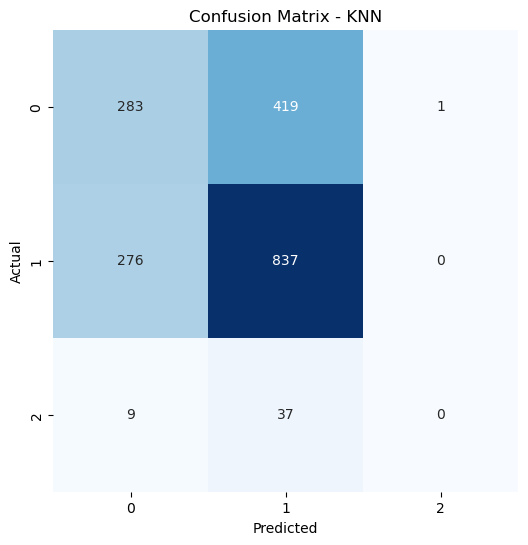

Classification Report - KNN:
              precision    recall  f1-score   support

           0       0.50      0.40      0.45       703
           1       0.65      0.75      0.70      1113
           2       0.00      0.00      0.00        46

    accuracy                           0.60      1862
   macro avg       0.38      0.38      0.38      1862
weighted avg       0.58      0.60      0.58      1862



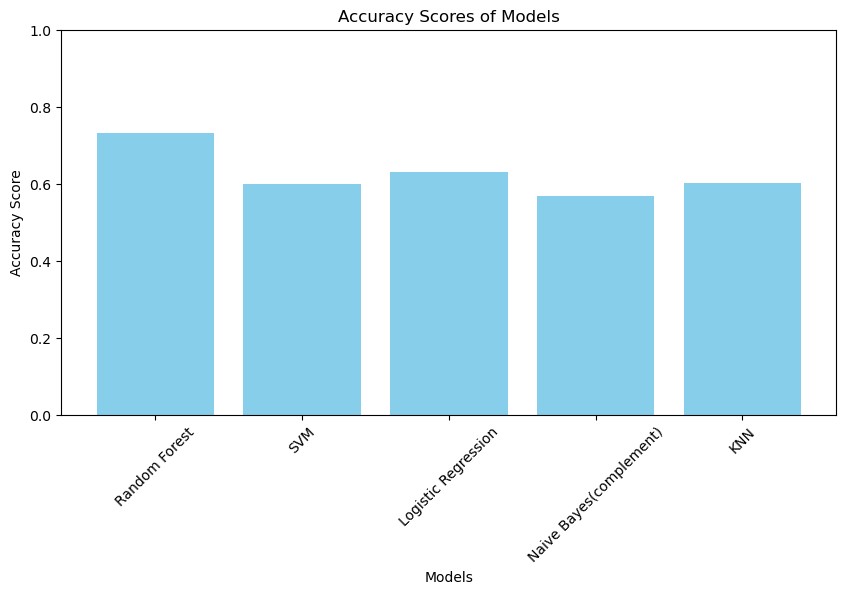

In [218]:
# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(), 
    'Naive Bayes(complement)': ComplementNB(),
    'KNN': KNeighborsClassifier(),
}

# Call the function to train and evaluate models
train_and_evaluate_models(models, X, y)

Function below incorporates the use of stratified k-fold cross validation of ML models  

In [219]:
def train_and_evaluate_models_with_cv(models, X, y, n_splits=5):
    """
    Train multiple machine learning models with stratified k-fold cross-validation,
    evaluate their performance, and plot the results including confusion matrices.
    
    Parameters:
        models (dict): A dictionary containing names of models as keys
                       and corresponding scikit-learn model objects as values.
        X (DataFrame or array-like): Features.
        y (array-like): Target variable.
        n_splits (int): Number of folds for stratified k-fold cross-validation.
    """
    # Initialize lists to store model names, accuracy scores, and confusion matrices
    model_names = []
    accuracy_scores = []
    confusion_matrices = []
    
    # Perform stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for name, model in models.items():
        # Initialize lists to store accuracy scores and confusion matrices for each fold
        fold_accuracy_scores = []
        fold_confusion_matrices = []
        
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Train the model
            model.fit(X_train, y_train)
            
            # Evaluate the model
            y_pred = model.predict(X_test)
            accuracy = model.score(X_test, y_test)
            conf_matrix = confusion_matrix(y_test, y_pred)
            
            # Store the accuracy score and confusion matrix for this fold
            fold_accuracy_scores.append(accuracy)
            fold_confusion_matrices.append(conf_matrix)
            
        # Calculate mean accuracy score and confusion matrix across all folds
        mean_accuracy = np.mean(fold_accuracy_scores)
        mean_conf_matrix = np.mean(fold_confusion_matrices, axis=0).astype(int)
        
        # Store the results
        model_names.append(name)
        accuracy_scores.append(mean_accuracy)
        confusion_matrices.append(mean_conf_matrix)
        
        # Plot confusion matrix
        plt.figure(figsize=(6, 6))
        sns.heatmap(mean_conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
                    xticklabels=model.classes_, yticklabels=model.classes_)
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
       
        # Print mean classification report
        print(f"Mean Classification Report - {name}:")
        print(classification_report(y_test, y_pred))
        print("="*60)
        
    # Plot mean accuracy scores
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, accuracy_scores, color='skyblue')
    plt.title('Mean Accuracy Scores of Models with Stratified K-Fold Cross-Validation')
    plt.xlabel('Models')
    plt.ylabel('Mean Accuracy Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.show()

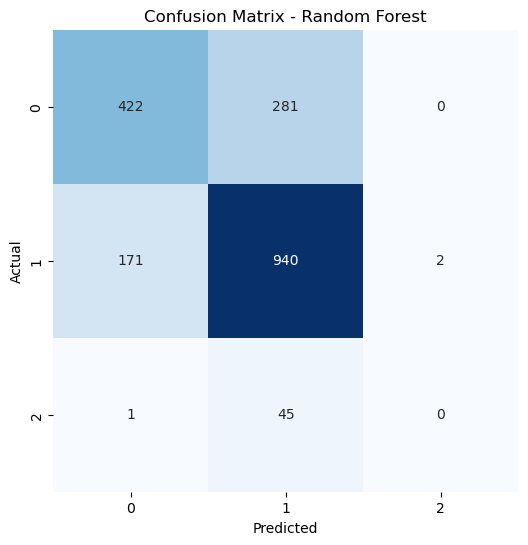

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65       703
           1       0.74      0.84      0.79      1113
           2       0.00      0.00      0.00        46

    accuracy                           0.73      1862
   macro avg       0.48      0.48      0.48      1862
weighted avg       0.71      0.73      0.72      1862



c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


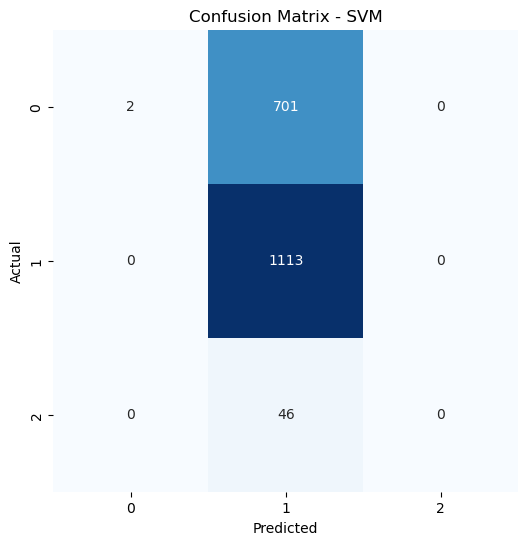

Classification Report - SVM:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       703
           1       0.60      1.00      0.75      1113
           2       0.00      0.00      0.00        46

    accuracy                           0.60      1862
   macro avg       0.53      0.33      0.25      1862
weighted avg       0.74      0.60      0.45      1862



c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

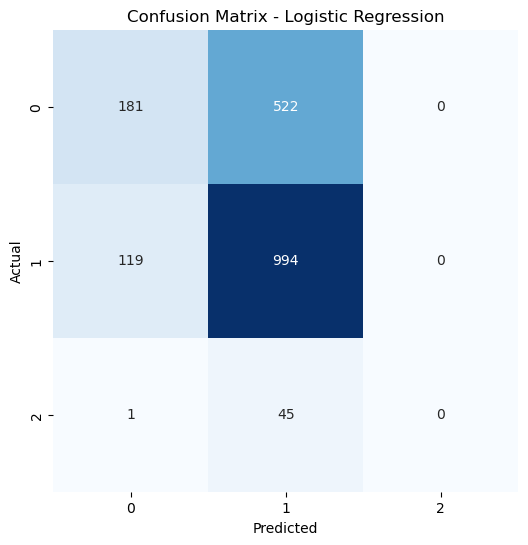

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.60      0.26      0.36       703
           1       0.64      0.89      0.74      1113
           2       0.00      0.00      0.00        46

    accuracy                           0.63      1862
   macro avg       0.41      0.38      0.37      1862
weighted avg       0.61      0.63      0.58      1862



c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\EWF\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


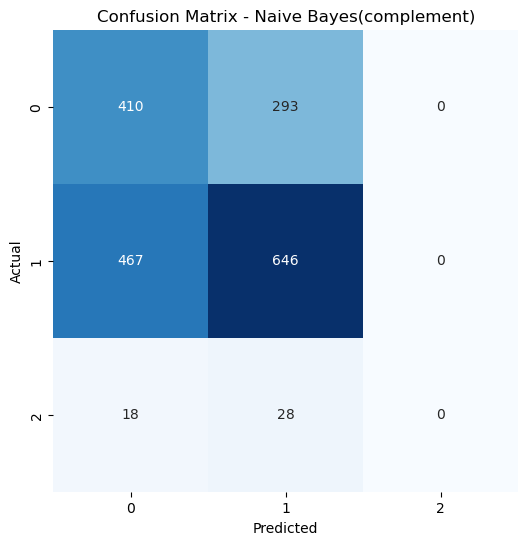

Classification Report - Naive Bayes(complement):
              precision    recall  f1-score   support

           0       0.46      0.58      0.51       703
           1       0.67      0.58      0.62      1113
           2       0.00      0.00      0.00        46

    accuracy                           0.57      1862
   macro avg       0.38      0.39      0.38      1862
weighted avg       0.57      0.57      0.57      1862



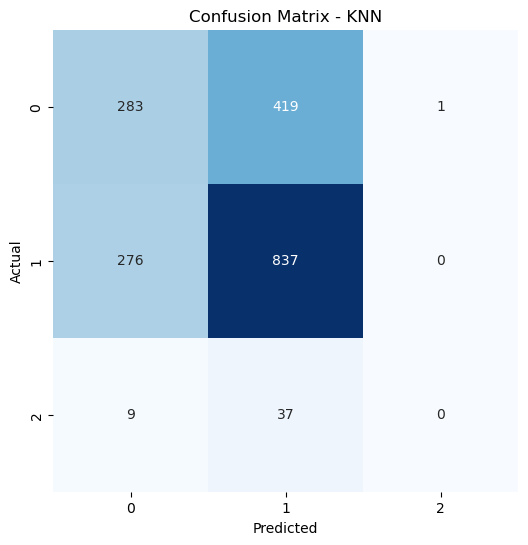

Classification Report - KNN:
              precision    recall  f1-score   support

           0       0.50      0.40      0.45       703
           1       0.65      0.75      0.70      1113
           2       0.00      0.00      0.00        46

    accuracy                           0.60      1862
   macro avg       0.38      0.38      0.38      1862
weighted avg       0.58      0.60      0.58      1862



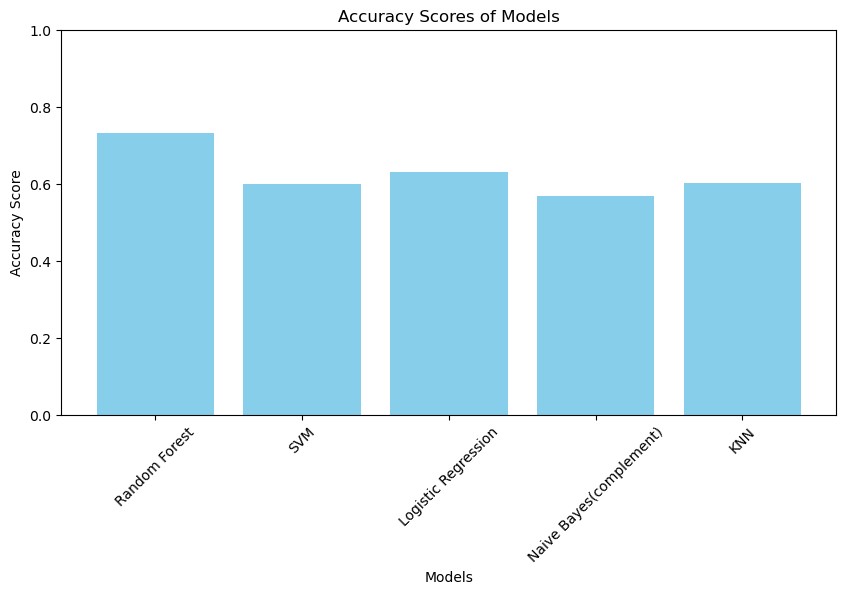

In [220]:
# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(), 
    'Naive Bayes(complement)': ComplementNB(),
    'KNN': KNeighborsClassifier(),
}

# Call the function to train and evaluate models
train_and_evaluate_models(models, X, y)

Imbalance ratio of the data

In [221]:
class_counts = df_mix['quality_label_encoded'].value_counts()

# defining the majority and minority classes is necessary to obtain the ratio as 
majority_class_count = class_counts.max()
minority_class_count = class_counts.min()

# Majority is divided between minority to obtain the ratio
imbalance_ratio = majority_class_count / minority_class_count

print("Imbalance Ratio:", imbalance_ratio) # output will provide the number of majority items per one minority item. If multiplied per 100, result will be in percentage. 

Imbalance Ratio: 20.77777777777778
